# User Guide 3: Diffusion Domination
## Introduction

In the Guides 1 and 2, we ran our first importance sampling simulation and then learnt how to combine different samples, respectively. We also looked at the analytical comparisons, which can be used in the drift dominated and interim cases, as well as some data analysis.

In this third and final guide, we will look at simulating the numerically complicated case of diffusion domination. To do this, we will further learn about the optional arguments for `fpt.numerics.is_simulation`, such as `x_r` and `estimator`. Semi-analytical comparisons, available for diffusion dominated quadratic inflation, will also be used.


As we go, we will also come to understand why importance sampling of the diffusion dominated case is difficult. The goal therefore is to introduce some of the current limitations of PyFPT.

In the last part, ways that PyFPT can be best optimised for your chosen use will be discussed. 

## Set Up and UV Boundary (`x_r`)
The imports and initial definitions are the same as before, except we will be using a larger mass of `m=1` to produce diffusion domination.

In [1]:
import pyfpt as fpt
import numpy as np
import matplotlib.pyplot as plt

import mpl_style
plt.style.use(mpl_style.paper_style)

# Will also need pandas to read the saved raw data
import pandas as pd
# Also need colours for a 2D histogram
from matplotlib.colors import LogNorm

In [2]:
phi_in = 42**0.5  # From N=0.25*(phi_in**2-phi_end**2) = 10
phi_end = 2**0.5  # Where slow-roll violation occurs

# For the above phi_in, this mass is results in diffusion domination
m = 1.


# Any slow-roll potential and its derivatives could be defined here
def V(phi):
    V = 0.5*(m*phi)**2
    return V


def V_dif(phi):
    V_dif = (m**2)*phi
    return V_dif


def V_ddif(phi):
    V_ddif = (m**2)
    return V_ddif


# Again, we need to define the drift and diffusion based on this potential
def drift_func(phi, N):
    return -2/phi

def diffusion_func(phi, N):
    pi = 3.141592653589793
    sqirt_6 = 2.449489742783178
    return (m*phi)/(2*pi*sqirt_6)

In [3]:
# The number of simulation runs
num_runs = 2*10**5

# Using a smaller bias amp in diffusion dom
bias_amp = 0.8

# Estimate a reasonable time step to use
std = fpt.analytics.variance_efolds(V, V_dif, V_ddif, phi_in, phi_end)**0.5
dN = std/(2*50)

There is the additional physical effect that as the field $\phi$ can now climb back up the potential $V(\phi)$ in diffusion domination, there is a dependance on the choice of a reflective boundary $\phi_{\rm UV}$. This is given as optional argument to `fpt.numerics.is_simulation` using `x_r=phi_UV`, where `x_r` is a general reflective boundary. For simplicity, initially we will choose the smallest value possible, which is just the initial field value. The default is to set unreachable UV boundary.

In [4]:
phi_UV = phi_in

This acts to suppress the probability of very large $\mathcal{N}$ instances. On the other hand, if $\phi_{\rm UV} \rightarrow \infty$, the probability of very large $\mathcal{N}$ ($\mathcal{N}>100$ ) is significant. This results in the problem of 'runaway' simulations, which we will encounter later in this guide.

## Simulating Finite $\phi_{\rm UV}$ 

Let's look at simulating the case of finite $\phi_{\rm UV}$ in diffusion domination.

### Estimator Used
For diffusion domination, we can't use the lognormal approximation for the distribution of the weights $w$ as we did in the previous guides. To show this numerically, let's try to do a simulation.

Number of cores used: 4
The simulations took: 124.89988443900074 seconds
Saved data to file IS_data_x_in_6.48_iterations_200000_bias_0.8.csv
Possibly not lognormal distribution, see p-value plots


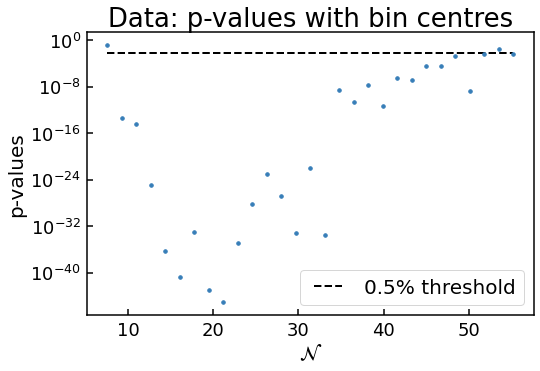

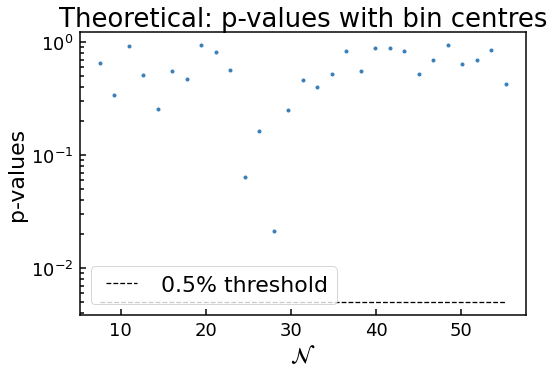

In [5]:
# Number of bins used in the histogram of FPTs used to estimate P(N)
num_bins = 50

# Returns the normalised histogram bin centres, heights and
# errors as a lists. Optional argument to apply UV boundary.
bin_centres, heights, errors =\
    fpt.numerics.is_simulation(drift_func, diffusion_func, phi_in, phi_end,
                               num_runs, bias_amp, dN, save_data=True,
                               estimator='lognormal', bins=num_bins,
                               x_r=phi_UV)

As before, the code has flagged the distribution as possibly not being lognormal according to the $p$ values. But this time it is clearly the case: what are the chances that randomly we have a distribution of weights in a bin that has a probability of $10^{-40}$ of being drawn from an underlying lognormal distribution?

So for diffusion domination, we will be limited to the less accurate na&#239;ve estimator for $P(\mathcal{N})$, limiting how far into the tail we can probe without increasing the number of runs.

### Using The Na&#239;ve Method

While we could run this simulation again using the na&#239;ve method, this would be ineffcient, as we have already saved the data to ``IS_data_x_in_6.48_iterations_200000_bias_0.8.csv``. So let's read the data from the file and re-analysis it using ``fpt.numerics.pdf_data_points``. Data analysis like truncation of runaway simulations has already been done.

This is the advantage of saving the raw data, as we can always re-analyse it!

In [6]:
# First, let's read the data
raw_data = pd.read_csv('IS_data_x_in_6.48_iterations_200000_bias_0.8.csv', index_col=0)

# Easier to work with NumPy arrays
N_values = np.array(raw_data['FPTs'])
w_values = np.array(raw_data['ws'])


# Then we can find the histogram bin heights and errors
# using the lognormal method. We are not saving the untruncated
# bins or num runs used
bin_centres, heights, errors, _, _ = fpt.numerics.data_points_pdf(N_values, w_values, 'naive', bins=num_bins)

# Easier to use numpy arrays rather than lists
bin_centres = np.array(bin_centres)
heights = np.array(heights)
errors = np.array(errors)

Again, we have saved the raw results for data analysis.

### Plotting 
Now let's plot this data

Text(0, 0.5, '$P(\\mathcal{N})$')

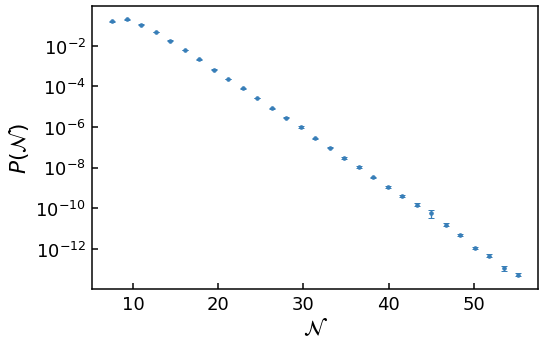

In [7]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7)
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')

As the y-axis is on a log scale and the data is approximately linear, clearly this is an exponential tail!

Unfortunately, analytical comparisons require techniques beyond PyFPT. See [Jackson *et al* 2022](https://arxiv.org/abs/2206.11234) for details.

### Raw Data Analysis

While we have been able to probe down to $P(\mathcal{N})\sim 10^{-10}$, we cannot go much further without increasing the number of runs. This can be understood by again plotting the 2D histogram of the raw data.

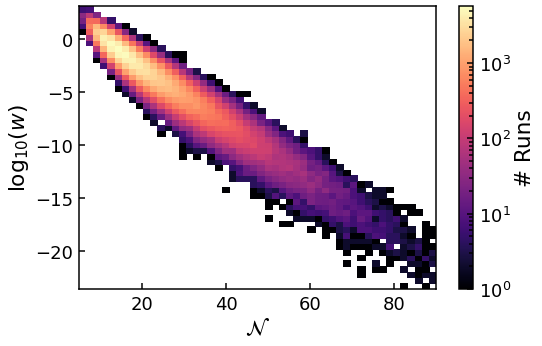

<Figure size 576x374.4 with 0 Axes>

In [8]:
plt.hist2d(N_values, np.log10(w_values), (num_bins, num_bins), norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'# Runs')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'${\rm log}_{10}(w)$')
plt.show()
plt.clf()

The data is not centred on the mean value of the sample, as was the case for $m=0.1$ (and smaller masses) in the previous guides. Instead, it *spreads* to larger $\mathcal{N}$ values rather than be contained in a closed contour. This problem can be more easily understood by further increasing the bias amplitude to 1.2 and plotting the data again.

Number of cores used: 4
The simulations took: 205.17434765899816 seconds
Saved data to file IS_data_x_in_6.48_iterations_200000_bias_1.2.csv


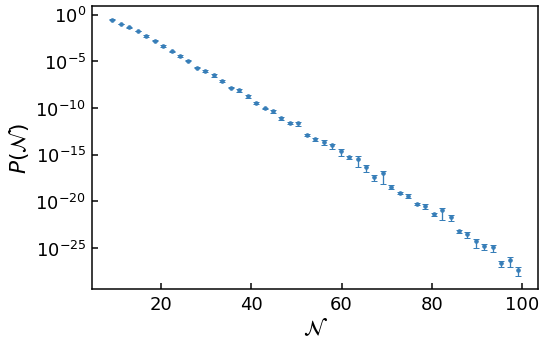

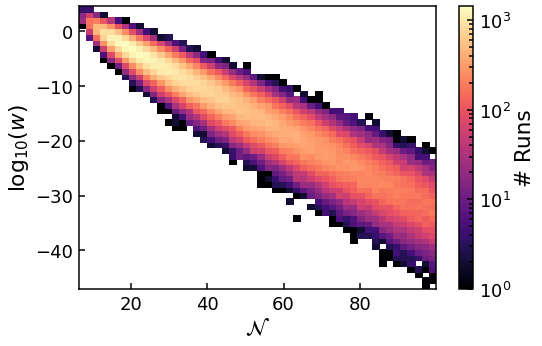

<Figure size 576x374.4 with 0 Axes>

In [9]:
# Increasing the bias amplitude from 0.8 used before
bias_amp = 1.2

# Returns the normalised histogram bin centres, heights and
# errors as a lists. Optional argument to apply UV boundary.
bin_centres, heights, errors =\
    fpt.numerics.is_simulation(drift_func, diffusion_func, phi_in, phi_end,
                               num_runs, bias_amp, dN, save_data=True,
                               estimator='naive', bins=num_bins,
                               x_r=phi_UV)

# Easier to use numpy arrays rather than lists
bin_centres = np.array(bin_centres)
heights = np.array(heights)
errors = np.array(errors)

# Plotting the data

plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7)
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.show()
plt.close()

# Plotting the raw data

# Note the bias value has changed
raw_data = pd.read_csv('IS_data_x_in_6.48_iterations_200000_bias_1.2.csv', index_col=0)

# Easier to work with NumPy arrays
N_values = np.array(raw_data['FPTs'])
w_values = np.array(raw_data['ws'])

plt.hist2d(N_values, np.log10(w_values), (num_bins, num_bins), norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'# Runs')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'${\rm log}_{10}(w)$')
plt.show()
plt.clf()

First, we see that while we have managed to probe further into the tail, the scatter of data points is much greater than with `bias_amp=0.8`, even for the same $\mathcal{N}$ bins. This is because the variance of the weights $w$ within each bin is much greater, varying over many orders of magnitude! As we are limited to the na&#239;ve estimator rather than the lognormal estimator, this is now a big problem. If we increase the `bias` any further, we can't trust the results as variance of weights within each bin is simply too great. There is also a large amount of scatter in the far tail results.

Second, the 2D histogram not only shows the spread of N to larger values much worse than with `bias=0.8`, but the majority of runs are still near the peak as well. So we can't 'tune' where the mean of the sample distribution, and those most of the runs are, like we could in the previous guides. Instead, we just sample a larger range of $\mathcal{N}$ until the variance of the weight per bin too large.

These two problems can only be solved by simply using more runs, such that even when the variance of the weights is very large and the values span many orders of magnitude, the na&#239;ve method for estimating $P(\mathcal{N})$ still converges. Far into the tail, this means we need to use $10^7$ or more runs.

### Analytical Comparisons for Finite $\phi_{\rm UV}$ 
Analytical comparisons are **not** available for finite $\phi_{\rm UV}$ in PyFPT. As they are beyond the scope of this guide. See [Jackson *et al* 2022](https://arxiv.org/abs/2206.11234) for details on cases where they can be derived.

## Simulating $\phi_{\rm UV} \rightarrow \infty$

This case suffers the from same issues as the finite case for diffusion domination, but to an even greater extent. But numerically results of the near tail can be obtained. 

Let's show this by running the simulations and plotting the data.

Number of cores used: 4
The simulations took: 113.55666194399964 seconds
Saved data to file IS_data_x_in_6.48_iterations_200000_bias_0.4.csv


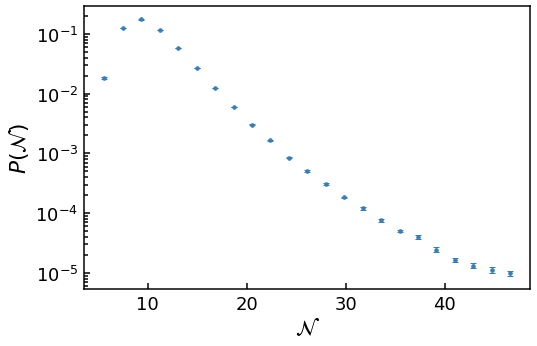

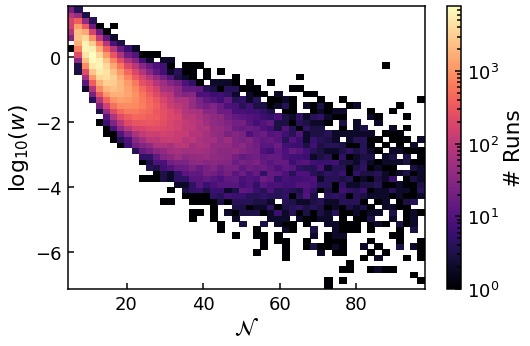

<Figure size 576x374.4 with 0 Axes>

In [10]:
# Need to use a smaller bias, as we numerical problems
# occur sooner than before.
bias_amp = 0.4

# Returns the normalised histogram bin centres, heights and
# errors as a lists. Optional argument to apply UV boundary.
bin_centres, heights, errors =\
    fpt.numerics.is_simulation(drift_func, diffusion_func, phi_in, phi_end,
                               num_runs, bias_amp, dN, save_data=True,
                               estimator='naive', bins=num_bins)

# Easier to use numpy arrays rather than lists
bin_centres = np.array(bin_centres)
heights = np.array(heights)
errors = np.array(errors)

# Plotting the data

plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7)
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.show()
plt.close()

# Plotting the raw data

# Note the bias value has changed. The file name does not record the phi_UV used
raw_data = pd.read_csv('IS_data_x_in_6.48_iterations_200000_bias_0.4.csv', index_col=0)

# Easier to work with NumPy arrays
N_values = np.array(raw_data['FPTs'])
w_values = np.array(raw_data['ws'])

plt.hist2d(N_values, np.log10(w_values), (num_bins, num_bins), norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'# Runs')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'${\rm log}_{10}(w)$')
plt.show()
plt.clf()

First, the tail is not a straight line (corresponding to an exponential on a log scale) but is inflected upwards, greatly increasing the likelihood of very large $\mathcal{N}$ events. 

Second, the problem of the spread of $\mathcal{N}$ increasing, while most of the values stay at the peak, is even worse then the finite $\phi_{\rm UV}$ case. This means the large $\mathcal{N}$ bins have less than 400 data points (the minimum found to give accurate error bars), and are truncated.

Third, the variance of the weights $w$ within each bin increase with $\mathcal{N}$ at an even greater rate than the finite $\phi_{\rm UV}$ case.

Both of these last two points mean we cannot probe as far into the tail of the $\phi_{\rm UV} \rightarrow \infty$, in terms of $P(\mathcal{N})$, as the finite $\phi_{\rm UV}$ case in diffusion domination.

### Analytical comparison $\phi_{\rm UV} \rightarrow \infty$
We can also include an analytical comparison for diffusion domination in quadratic inflation, using the results of [Pattison *et al* 2017](https://arxiv.org/abs/1707.00537). This is done for each of the provided $\mathcal{N}$ values. Currently, no other analytical comparisons for diffusion domination are included.

In [11]:
# This can take up to 4 minutes to evaluate
analytical_heights = fpt.analytics.quadratic_inflation_large_mass_pdf(bin_centres, m, phi_in)

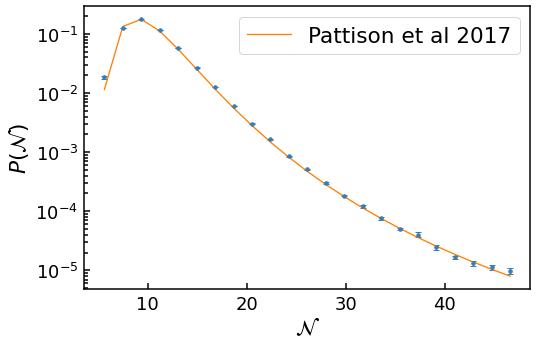

In [12]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7)
plt.plot(bin_centres, analytical_heights, label='{0}'.format('Pattison et al 2017'))
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.legend()
plt.show()
plt.close()

## Advanced Use Cases and Your Contribution
The guides have focused on using the PyFPT as it can be installed, without understanding the code behind it. Additional numerical efficiency can be obtained by manually editing PyFPT, as well as adapting to other purposes.


The code which runs the simulations uses [Cython](https://cython.org/), which allows Python code to be complied into C for numerical efficiency. There is no hard cutoff between Python and C when using Cython. Instead, it cleverly compiles as much of the Cython code into C as possible. As we provide the information on the drift and diffusion using Python functions, PyFPT is inherently not as efficient as possible. This can be a problem in drift dominated case, as the simulation times can be very long.

This can be solved by editting Cython module `fpt.numerics.importance_sampling_cython.pyx`. In the installed version of PyFPT, this module is partly hidden from the user, as it's correct use requires additional technical knowledge. The module `fpt.numerics.is_simulation` is used as a wrapper for this purpose. But if one is interested in analysing the tail of a particular inflation model, a clone of PyFPT can be made and edited it to contain drift and diffusion as Cython functions in `fpt.numerics.importance_sampling_cython.pyx`, meaning they will be compiled into C. This change will to give at least a factor of 2 speed up or more. Of course, this requires knowledge of Cython...

Additionally, the bias $\mathcal{B}(\phi)$ can be optimized to reduce the spread of $w$ within each bin to reduce the number of runs required for an accurate estimation of $P(\mathcal{N})$ and further increase the numerical efficiency. This is done by using a function instead of a scalar for the `bias` argument of `fpt.numerics.is_simulation`. For drift-domination, `fpt.analytics.optimal_bias_amplitude` can also be used to define the bias amplitude such that the region of interest is investigated. As yet, the optimal form for the bias function has not yet been determined.

**Using PyFPT for advanced cases requires additional technical knowledge and time commitment.** I'm more than happy to help in this endeavour, be it by sharing resources on learning about Cython, or just tech support! I can be contacted at joseph.jackson@port.ac.uk.

Let's make PyFPT as useful as possible for the community interested in stochastic simulations!